In [79]:
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from sklearn.feature_selection import chi2
import scipy.stats as st
from sklearn import metrics

In [80]:
#read files from the excel sheet
xls = pd.ExcelFile('K:\PPData.xlsx')
practice = pd.read_excel(xls, 'Practice')
payments = pd.read_excel(xls, 'Payments')
charges = pd.read_excel(xls,'Charges')

In [81]:
#ensuring the right data is loaded
practice.head()
payments.head()
charges.head()

,Practice ID,Charge ID,Charge Date,Patient ID,Charge Amount,Charge Type,Patient Age
0,6120,6120_11364675,2021-04-18,6120_329154,16.70,COPAY,25
1,19851,19851_483405,2021-02-05,19851_86429,212.04,DEDUCTIBLE,90
2,19851,19851_473580,2021-01-22,19851_86429,132.06,DEDUCTIBLE,90
3,19851,19851_491385,2021-02-19,19851_86429,25.00,COINSURANCE,90
4,19851,19851_572250,2021-06-11,19851_86429,25.00,COINSURANCE,90


In [82]:
#basic description of values
practice.describe()
payments.describe()
charges.describe()

,Practice ID,Charge Amount,Patient Age
count,100107.000000,100107.000000,100107.00000
mean,4216.483563,63.753070,40.46751
std,3290.831231,170.348759,22.40039
min,57.000000,0.000000,0.00000
25%,1272.000000,14.750000,24.00000
50%,4479.000000,30.000000,38.00000
75%,6120.000000,66.220000,58.00000
max,19851.000000,12500.000000,103.00000


In [83]:
#lets focus on practice to answer the first question in the assessment
#checking for nulls in the dataset
practice.isnull().sum()

Practice ID              0
Specialty                0
Size                     0
Statement Pay Enabled    0
Guest Pay Enabled        0
Portal Pay Enabled       0
dtype: int64

In [84]:
practice.shape


(39, 6)

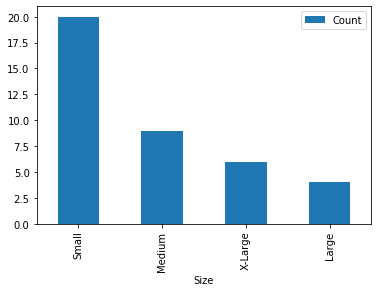

In [85]:
#size of practices 
size_count = pd.DataFrame(practice.groupby('Size').size().sort_values(ascending=False).rename('Count').reset_index())
size_count.head()
size_count.plot(x='Size',y='Count',kind='bar')

#dataset hs a lot of small practices involved.

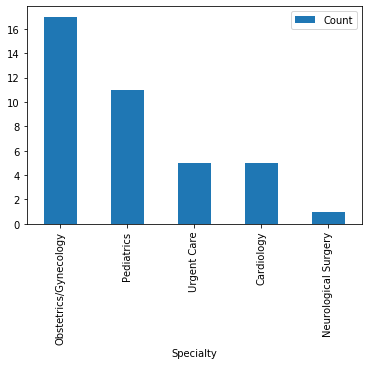

In [86]:
#speciality spread in practices
sp_count = pd.DataFrame(practice.groupby('Specialty').size().sort_values(ascending=False).rename('Count').reset_index())
sp_count.head()
sp_count.plot(x='Specialty',y='Count',kind='bar')

#most dominant being ob/gyn, helpful to look at other specialities and ER more specifically.

Statement Pay Enabled  N   Y
Size                        
Large                  0   4
Medium                 1   8
Small                  2  18
X-Large                2   4


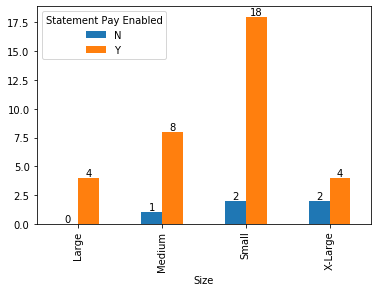

In [87]:
# Cross tabulation between Size and Statement Pay
CrosstabResult=pd.crosstab(index=practice['Size'],columns=practice['Statement Pay Enabled'])
print(CrosstabResult)

ax = CrosstabResult.plot.bar()
#Most small sized practices opt for statement pay

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')


Guest Pay Enabled  N   Y
Size                    
Large              0   4
Medium             1   8
Small              2  18
X-Large            0   6


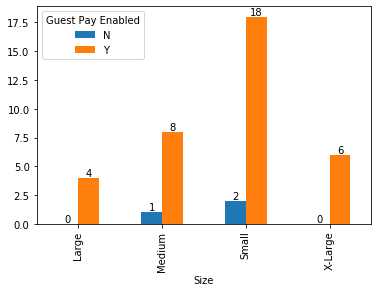

In [88]:
# Cross tabulation between Size and Guest Pay
CrosstabResult1=pd.crosstab(index=practice['Size'],columns=practice['Guest Pay Enabled'])
print(CrosstabResult1)

ax = CrosstabResult1.plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')


Portal Pay Enabled  N   Y
Size                     
Large               1   3
Medium              1   8
Small               4  16
X-Large             3   3


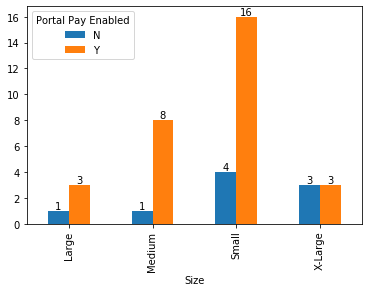

In [89]:
# Cross tabulation between Size and Portal Pay
CrosstabResult2=pd.crosstab(index=practice['Size'],columns=practice['Portal Pay Enabled'])
print(CrosstabResult2)

ax = CrosstabResult2.plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')


In [90]:
#converting to numeric
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder() 
practice['speX'] = lb.fit_transform(practice['Statement Pay Enabled'])
practice['gpeX'] = lb.fit_transform(practice['Guest Pay Enabled'])
practice['ppeX'] = lb.fit_transform(practice['Portal Pay Enabled'])

In [91]:
practice.head()

,Practice ID,Specialty,Size,Statement Pay Enabled,Guest Pay Enabled,Portal Pay Enabled,speX,gpeX,ppeX
0,57,Obstetrics/Gynecology,Small,Y,Y,Y,1,1,1
1,72,Pediatrics,Small,Y,Y,Y,1,1,1
2,129,Obstetrics/Gynecology,Small,Y,Y,Y,1,1,1
3,210,Obstetrics/Gynecology,Small,Y,Y,Y,1,1,1
4,219,Obstetrics/Gynecology,X-Large,Y,Y,Y,1,1,1


In [92]:
#to see if practices had all 3 payment modes enabled
practice['Count of Online payment options'] = practice['speX'] + practice['gpeX'] + practice['ppeX'] 

Count of Online payment options
1     7
2     3
3    29
Name: Practice ID, dtype: int64


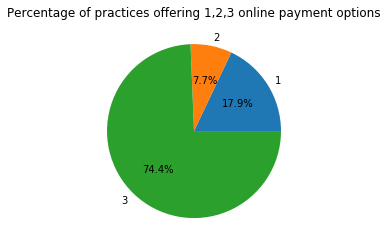

In [93]:
hospital_count = practice.groupby('Count of Online payment options')['Practice ID'].count()
print(hospital_count)

# Create the pie chart
plt.pie(hospital_count, labels=hospital_count.index, autopct='%1.1f%%')

# Add a title
plt.title('Percentage of practices offering 1,2,3 online payment options')

# Display the chart
plt.show()

Count of Online payment options  1  2   3  Total
Size                                            
Large                            0  1   3      4
Medium                           1  1   7      9
Small                            4  0  16     20
X-Large                          2  1   3      6
Total                            7  3  29     39


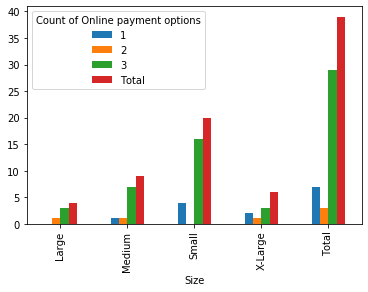

In [94]:
CrosstabResult4=pd.crosstab(index=practice['Size'],columns=practice['Count of Online payment options'],margins=True, margins_name='Total')
print(CrosstabResult4)

CrosstabResult4.plot.bar()
#all pratices had atleast 1 of the three forms of payment enabled. 

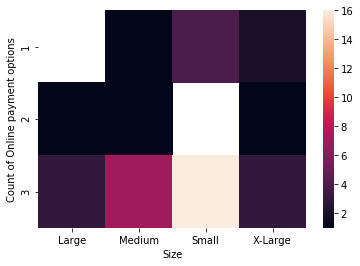

In [95]:
#Heat map for between size of practices and total payment types enabled. 
#large firms had atleast 2 types enabled, other types had atleast 1 payment type
st = practice[['Size','Count of Online payment options']]
st_plot = pd.DataFrame(st.groupby(['Size','Count of Online payment options']).size().sort_values(ascending=False).rename('Count').reset_index())
st_matrix = st_plot.pivot_table(values='Count',index='Count of Online payment options',columns='Size')
sns.heatmap(st_matrix)

In [96]:
practice['Size'] = practice['Size'].astype('string')
practice['Specialty'] = practice['Specialty'].astype('string')
practice['Statement Pay Enabled'] = practice['Statement Pay Enabled'].astype('string')
practice['Guest Pay Enabled'] = practice['Guest Pay Enabled'].astype('string')
practice['Portal Pay Enabled'] = practice['Portal Pay Enabled'].astype('string')
practice.dtypes

Practice ID                         int64
Specialty                          string
Size                               string
Statement Pay Enabled              string
Guest Pay Enabled                  string
Portal Pay Enabled                 string
speX                                int32
gpeX                                int32
ppeX                                int32
Count of Online payment options     int32
dtype: object

In [97]:
#Null hypothesis: There is no relationship between Practice size and Statement Pay Enabled
#Alternate hypothesis: There is a relationship between Practice size and Statement Pay Enabled

contingency_table = pd.crosstab(practice['Size'], practice['Statement Pay Enabled'])

# Perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the test statistic, p-value, degrees of freedom, and expected frequencies
print("Chi-square test statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square test statistic: 3.0129411764705885
P-value: 0.38963420184480085
Degrees of freedom: 3
Expected frequencies:
 [[ 0.51282051  3.48717949]
 [ 1.15384615  7.84615385]
 [ 2.56410256 17.43589744]
 [ 0.76923077  5.23076923]]


In [98]:
#Null hypothesis: There is no relationship between Practice size and Portal Pay Enabled
#Alternate hypothesis: There is a relationship between Practice size and Portal Pay Enabled

contingency_table = pd.crosstab(practice['Size'], practice['Portal Pay Enabled'])

# Perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the test statistic, p-value, degrees of freedom, and expected frequencies
print("Chi-square test statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square test statistic: 3.290925925925926
P-value: 0.3489075850222059
Degrees of freedom: 3
Expected frequencies:
 [[ 0.92307692  3.07692308]
 [ 2.07692308  6.92307692]
 [ 4.61538462 15.38461538]
 [ 1.38461538  4.61538462]]


In [99]:
#Null hypothesis: There is no relationship between Practice size and Guest Pay Enabled
#Alternate hypothesis: There is a relationship between Practice size and Guest Pay Enabled

contingency_table = pd.crosstab(practice['Size'], practice['Guest Pay Enabled'])

# Perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the test statistic, p-value, degrees of freedom, and expected frequencies
print("Chi-square test statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square test statistic: 1.1314814814814813
P-value: 0.7694802741825926
Degrees of freedom: 3
Expected frequencies:
 [[ 0.30769231  3.69230769]
 [ 0.69230769  8.30769231]
 [ 1.53846154 18.46153846]
 [ 0.46153846  5.53846154]]


In [ ]:
#since all the three p values are high, we can accept the null hypothesis and 
#accept that the size of firms do not affect the payment modes enabled.

In [105]:
#patient age analysis
# Create a new column 'AgeRange' based on the age ranges
buckets = [0, 10, 20, 30, 40, 50,60,70,80, 90,float('inf')]
labels = ['0', '10', '20', '30', '40','50','60','70','80','90']

# Create a new column 'AgeRange' based on the age ranges
charges['AgeRange'] = pd.cut(charges['Patient Age'], bins=buckets, labels=labels)

In [106]:
# Create a contingency table
contingency_table = pd.crosstab(payments['Payment Method'],charges['AgeRange'])

# Print the contingency table
print(contingency_table)
#but these values have duplicates because patient age is linked with charges and there can be multiple charges and payments

AgeRange           0    10     20     30    40    50    60    70    80   90
Payment Method                                                             
GUEST PAY        402   349    795    926   562   536   464   286   128   29
OTHER           5999  6544  11756  11740  8242  8213  8048  5607  2327  392
PORTAL PAY       504   511   1157   1279   758   792   777   450   174   18
STATEMENT PAY   1002   912   1875   2081  1294  1173  1111   694   286   43


In [107]:
#Null hypothesis: There is no relationship between payment method and age range
#Alternate hypothesis: There is a relationship between payment method and age range
# Create the contingency table using crosstab
contingency_table = pd.crosstab(payments['Payment Method'],charges['AgeRange'])

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p_value)
print("Expected frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

#with low p values, we reject null hypothesis and establish that there is relationship between age ranges and payment methods.

Chi-squared statistic: 238.24008820900326
Degrees of freedom: 27
P-value: 1.0744280785508294e-35
Expected frequencies:
AgeRange                  0           10            20            30  \
Payment Method                                                         
GUEST PAY        392.300623   412.592890    773.140332    795.119487   
OTHER           6034.612306  6346.760583  11892.925706  12231.022740   
PORTAL PAY       562.557516   591.656545   1108.680128   1140.198147   
STATEMENT PAY    917.529556   964.989982   1808.253834   1859.659626   

AgeRange                 40           50           60           70  \
Payment Method                                                       
GUEST PAY        538.613325   531.568088   515.989184   349.136143   
OTHER           8285.285341  8176.911122  7937.266723  5370.629416   
PORTAL PAY       772.369343   762.266501   739.926415   500.659825   
STATEMENT PAY   1259.731992  1243.254289  1206.817678   816.574615   

AgeRange                 80

In [108]:
#contingency table
observed = np.array([[196, 125,515,589,350,296,301,225,58,7], 
                     [2453, 2563,4668,4701,3566,3482,3612,2775,1259,236],
                     [404, 237,287,531,328,225,242,125,35,7],
                     [428,487,908,1199,638,503,404,137,41,4]])
                    
                     
# Perform the chi-squared test
chi2, p_value, dof, expected = chi2_contingency(observed)

# Print the results
print("Chi-squared statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p_value)
print("Expected frequencies:", expected)

#after removing duplicates[checked values on Tableau], we still see low p- value implying rejection of null hypothesis.

Chi-squared statistic: 1124.7857988271462
Degrees of freedom: 27
P-value: 8.090494261250005e-220
Expected frequencies: [[ 236.70835568  232.01634863  433.7046517   477.3607173   331.97649884
   306.40846042  310.01246583  221.81633331   94.72414234   17.27202595]
 [2606.72631364 2555.05607071 4776.12767262 5256.8855851  3655.85689836
  3374.29151659 3413.98025391 2442.72945564 1043.13983192  190.20640151]
 [ 215.2783355   211.01111196  394.43988045  434.14361254  301.92152655
   278.66825044  281.94597287  201.73453905   86.14844049   15.70833014]
 [ 422.28699517  413.91646869  773.72779523  851.61008506  592.24507625
   546.63177255  553.06130738  395.71967201  168.98758526   30.81324239]]
